In [ ]:
from numpy.random import normal
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from scipy import ndimage
import utils as utils 
import pandas as pd 

In [2]:
#test function to load gaia data -- reset median_ra and median_dec to
#test values around edges of survey 
#set parameters 
grid_size=96
edge_size = 6
front = int(edge_size)
back = int(grid_size-edge_size)

#center of the sky field in RA and DEC 
median_ra = 2.5
median_dec = 0


#width of the field in gnomonic coordinates 
gnomonic_width = 0.0175

#width of the proper motion field 
pmfield_size = 5.0 

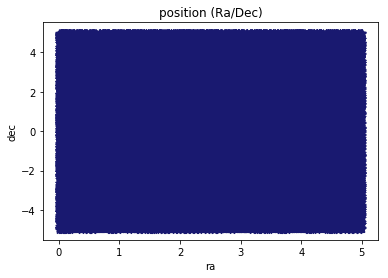

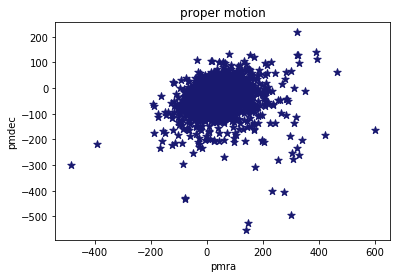

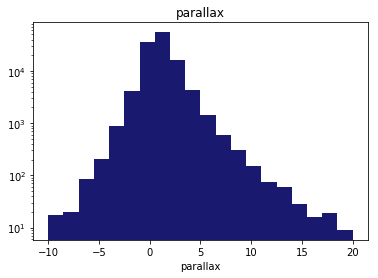

In [3]:
#load example gaia data and plot distributions 

data = pd.read_csv('gaia_example_data.csv')

plt.scatter(data['ra'], data['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('position (Ra/Dec)')

plt.show()

plt.scatter(data['pmra'], data['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.title('proper motion')

plt.show()

parallax = data['parallax']

plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
plt.yscale('log')
plt.xlabel('parallax')
plt.title('parallax')

plt.show()



In [4]:
#apply position, proper motion, and parallax cuts 
data1 = data 
data, x, y = utils.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)

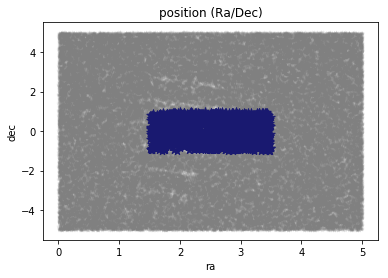

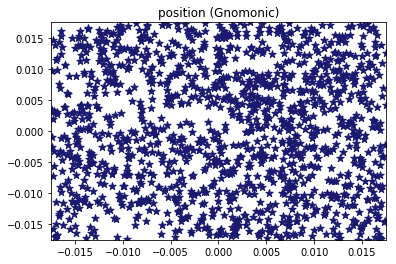

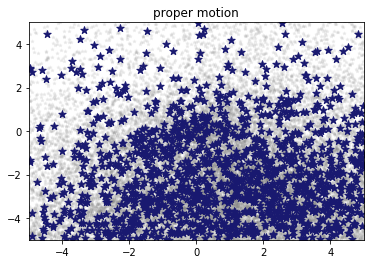

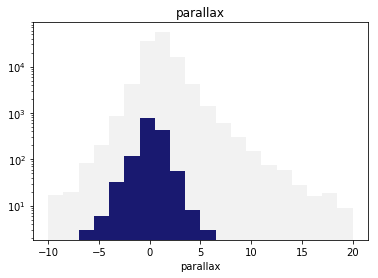

In [5]:
#check masking and gnomonic projection 
plt.scatter(data1['ra'], data1['dec'], c='grey',alpha=0.1, s=10,marker='*')
plt.scatter(data['ra'], data['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('position (Ra/Dec)')
plt.show()


plt.scatter(x,y, c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position (Gnomonic)')


plt.show()
plt.scatter(data1['pmra'], data1['pmdec'], c='grey',alpha=0.1, s=10,marker='*')
plt.scatter(data['pmra'], data['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlim([-pmfield_size,pmfield_size])
plt.ylim([-pmfield_size,pmfield_size])
plt.title('proper motion')

plt.show()

parallax = data['parallax']
plt.hist(data1['parallax'], bins = 20, range=(-10, 20), color='grey',alpha=0.1)
plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
plt.yscale('log')
plt.xlabel('parallax')
plt.title('parallax')

plt.show()

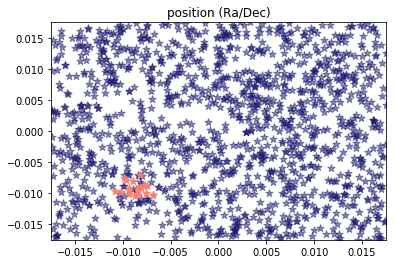

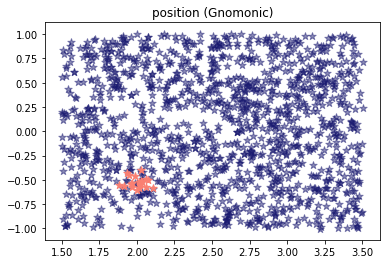

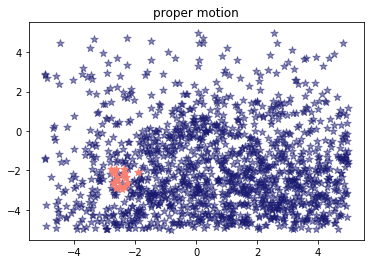

In [6]:
#test pipeline for simple gaussian "mock injection" 

#generate mock data 
xx = normal(-gnomonic_width/2, gnomonic_width/20, 20)
yy = normal(-gnomonic_width/2, gnomonic_width/20, 20)
pmra = normal(-pmfield_size/2, pmfield_size/20, 20)
pmdec = normal(-pmfield_size/2, pmfield_size/20, 20)

plt.scatter(x,y, c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(xx,yy, c='salmon',alpha=1.,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position (Ra/Dec)')

plt.show()

#transform data to Ra/Dec  
ra_inj, dec_inj = utils.from_gnomonic(xx,yy,median_ra,median_dec)
plt.scatter(data['ra'],data['dec'],c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(ra_inj, dec_inj, c='salmon',alpha=1.,marker='*',s=60)
plt.title('position (Gnomonic)')

plt.show()

plt.scatter(data['pmra'],data['pmdec'],c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(pmra, pmdec,  c='salmon',alpha=1.,marker='*',s=60)
plt.title('proper motion')

plt.show()

In [7]:
#inject stars into Gaia dataand re-apply masking 
df = pd.DataFrame(columns=data.keys())
for k in (data.keys()):
    df[k] = np.ones(len(xx))
df['pmra'] = pmra
df['pmdec'] = pmdec
df['ra'] = ra_inj
df['dec'] = dec_inj

data = data.append(df)
data, x, y = utils.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)

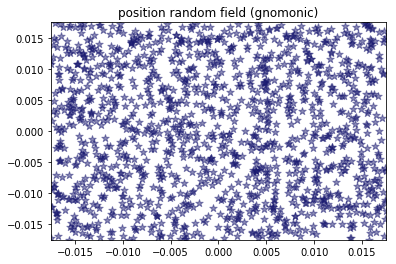

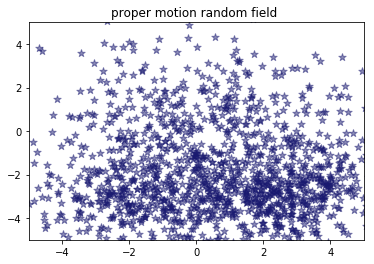

In [8]:
#generate random comparison field 

#generate random field 
rand_ra, rand_dec, rand_pmra, rand_pmdec = utils.make_random_image(data, x, y, gnomonic_width, pmfield_size)


plt.scatter(rand_ra, rand_dec,c='midnightblue',alpha=.5,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position random field (gnomonic)')

plt.show()

plt.scatter(rand_pmra, rand_pmdec,c='midnightblue',alpha=.5,marker='*',s=60)

plt.title('proper motion random field ')
plt.xlim([-pmfield_size,pmfield_size])
plt.ylim([-pmfield_size,pmfield_size])
plt.show()


(96, 96, 96, 96)


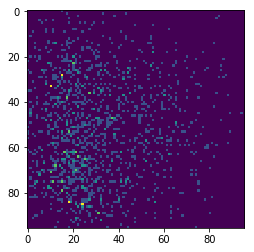

In [9]:
#generate histograms for wavelet transformation 

full_field = np.c_[x, y, data['pmra'], data['pmdec']]

random_field = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]

#generate histograms 
field_image, edges = utils.make_field_image(full_field, gnomonic_width, pmfield_size, grid_size)
random_image, edges = utils.make_field_image(random_field, gnomonic_width, pmfield_size, grid_size)

print(random_image.shape)

plt.imshow(random_image.sum(axis=(0,1)), origin='upper')
plt.show()

In [11]:
field_image, edges = utils.make_field_image(full_field, gnomonic_width, pmfield_size, grid_size)

In [12]:
#plot smoothed field before transformation 
smooth_field = ndimage.filters.gaussian_filter(field_image,3.0)

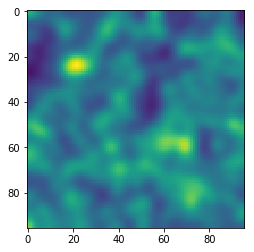

In [13]:
plt.imshow(smooth_field.sum(axis=(2,3))/np.max(smooth_field.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()


In [14]:
#run wavelet function on real and random field 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

wv = utils.WaveNet(grid_size, grid_size, J=4, wavelets = ['bior5.5'])
out = wv(torch.Tensor(field_image).to(device)).to('cpu').numpy()
rand_out = wv(torch.Tensor(random_image).to(device)).to('cpu').numpy()

cpu


In [15]:
#apply smoothing 
out = ndimage.filters.gaussian_filter(out,3.0)
rand_out = ndimage.filters.gaussian_filter(rand_out,3.0)

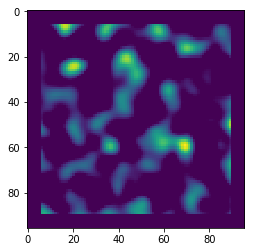

In [16]:
#remove outer edges of image 
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1

plt.imshow(out1.sum(axis=(2,3))/np.max(out1.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()

In [17]:
#standardize the real output 
out = (out-np.mean(rand_out))/np.std(rand_out)

In [18]:
#apply threshold 
edge_size = 6
front = int(edge_size)
back = int(grid_size-edge_size)
nstars = len(data)

#apply significance correction 
out = out / (-0.9*np.log10(nstars)+5.)

#applying thresholding 
mask = out < 5.0 
out[mask] = 0

#remove outer edges of image
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1


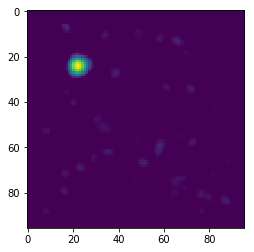

In [19]:
plt.imshow(out1.sum(axis=(2,3)))
plt.show()

In [20]:
#find remaining hotspots 
blobs, significance = utils.find_blobs(out1, threshold=9)

In [21]:
print(blobs)
print(significance)

[[23.989990900818928, 22.210646041856233, 23.19912041249621, 24.645890203215043, 9.504476986487129, 9.803705110307408, 8.858892671024561, 12.114724091300149]]
[19.718881607055664]


In [22]:
#find clusters in original dataset 
clusters = utils.find_clusters(data, x, y, gnomonic_width, pmfield_size, grid_size, blobs)

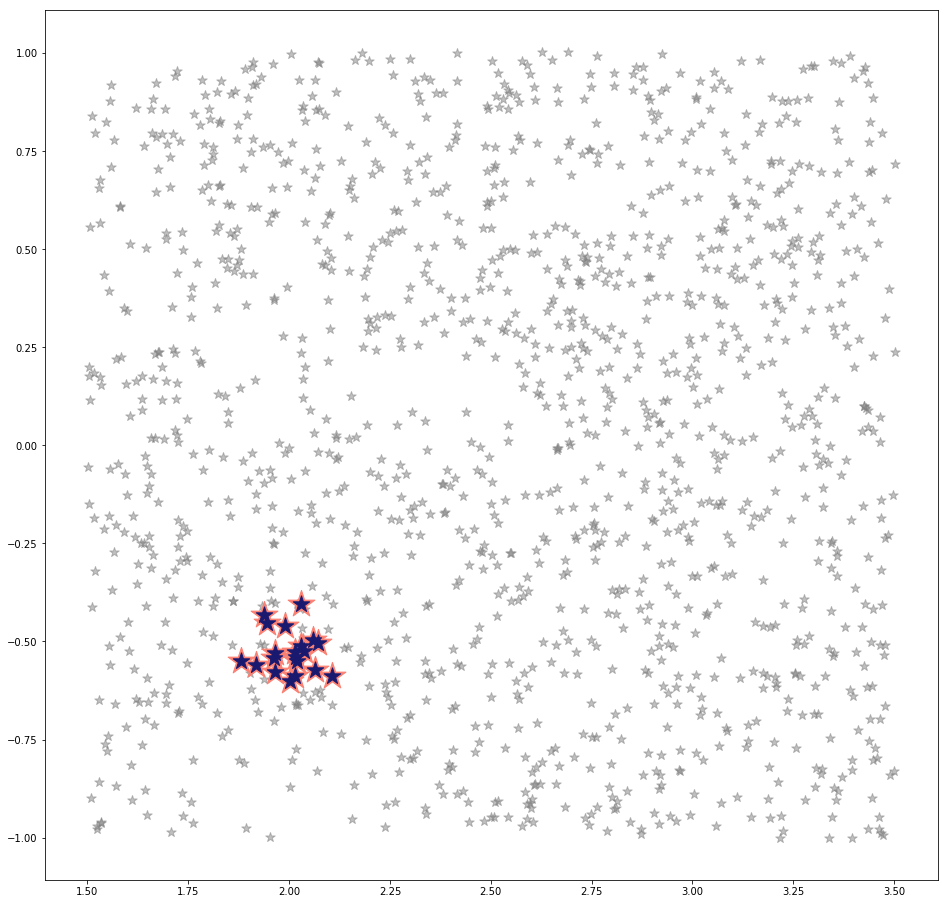

all injected stars recovered successfully!


In [25]:
fig, ax = plt.subplots(figsize=(16,16))

#plot background stars 
plt.scatter(data['ra'],data['dec'], alpha=0.5, color='grey', s=100, marker='*')

#plot injected stars 
plt.scatter(df['ra'], df['dec'], alpha=1., color='salmon',s=800, marker='*')

#plot returned stars
for cluster in clusters:
    if(len(cluster)>=5):
        plt.scatter(cluster['ra'], cluster['dec'], color='midnightblue',s=300, marker='*')

plt.show()

mask = np.isin(cluster['ra'], df['ra'])

if(len(cluster[mask]==len(df))):
    print('all injected stars recovered successfully!')

In [24]:
#calculate cluster poission significance 

#first filter field stars by cluster proper motio n
maxpmra = np.max(cluster['pmra'])
minpmra = np.min(cluster['pmra'])
maxpmdec = np.max(cluster['pmdec'])
minpmdec = np.min(cluster['pmdec'])

mask1 = data['pmra'] <= maxpmra
mask2 = data['pmra'] >= minpmra
mask3 = data['pmdec'] <= maxpmdec
mask4 = data['pmdec'] >= minpmdec
mask = mask1 & mask2 & mask3 & mask4
    
#calculate poisson rate for remaining stars 
poisson_rate = len(x[mask])
x_clust, y_clust = utils.to_gnomonic(cluster['ra'], cluster['dec'], median_ra, median_dec) 
area = (np.pi/4*(np.max(x_clust) - np.min(x_clust))*(np.max(y_clust) - np.min(y_clust)))/(4*gnomonic_width**2)

#calculate poisson significance 
poisson_int = (np.mean(scipy.stats.poisson(poisson_rate*area).rvs(10000)))
significance_poisson = ((len(cluster)-poisson_int)/np.sqrt(poisson_int))

print('wavelet significance: ' + str(np.round(significance[0], 2)))
print('poisson significance: ' + str(np.round(significance_poisson)))


wavelet significance: 19.72
poisson significance: 36.0
